# Imports

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# Configs

In [69]:
INPUT_PATH = 'datasets/'
ARIMA_PATH = 'statics/arima_predict.parquet'
OUTPUT_PATH_TEST = 'results/ridge_test_predictions.parquet'
OUTPUT_PATH_TRAIN = 'results/ridge_train_predictions.parquet'

START_DATE = '2023-01-01'
END_DATE = '2023-04-30'

FEATURE_LIST = [#'ARIMA_predicts',
                # 'borough',
                
                #'Previous_week_trip_dist',
                #'Previous_2week_trip_dist',
                #'Previous_day_trip_dist',

                # 'Previous_week_passenger_count',
                # 'Previous_2week_passenger_count',
                # 'Previous_day_passenger_count',

                # 'Previous_week_fare_amount',
                # 'Previous_day_fare_amount',
                # 'Previous_2week_fare_amount',
                #'group',

                'Previous_2week_demand',
                'Previous_week_demand', 

                'Previous_day_demand',
                'Previous_2day_demand',
                'Previous_3day_demand',
                'Previous_4day_demand',
                'Previous_5day_demand',
                'Previous_6day_demand',
                'Previous_8day_demand',
                'Previous_9day_demand',
                'Previous_10day_demand',
                'Previous_11day_demand',
                'Previous_12day_demand',
                'Previous_13day_demand',

                # 'Previous_week_extra',
                # 'Previous_2week_extra',
                # 'Previous_day_extra',
                
                # 'Previous_2week_RatecodeID',
                # 'Previous_week_RatecodeID',
                # 'Previous_day_RatecodeID',

                # 'Previous_week_congestion_surcharge',
                # 'Previous_2week_congestion_surcharge',
                # 'Previous_day_congestion_surcharge',

                # 'Day_of_month', 
                # 'Day_of_week',
                # 'Location'
                ]

TEST_START_DATE = '2023-04-01'
GROUP_NUM = 2
AUTO_TUNE = False

# Data preparation


## Load Data

In [3]:
def load_data(path, start_date: str, end_date: str):
    df = pd.read_parquet(path)
    start_date = datetime.date.fromisoformat(start_date)
    end_date = datetime.date.fromisoformat(end_date)
    filtered_df = df[(df['tpep_pickup_datetime'].dt.date >= start_date) &
                     (df['tpep_pickup_datetime'].dt.date <= end_date)]
    dataset = filtered_df.filter(items=['tpep_pickup_datetime', 'PULocationID'])
    dataset['PU_date'] = pd.to_datetime(dataset['tpep_pickup_datetime'].dt.date)
    return dataset

In [4]:
rides_df = load_data(INPUT_PATH, START_DATE, END_DATE)

In [5]:
print(f'rides dataframe shape : {rides_df.shape}')
rides_df.head()

rides dataframe shape : (12672629, 3)


,tpep_pickup_datetime,PULocationID,PU_date
0,2023-01-01 00:32:10,161,2023-01-01
1,2023-01-01 00:55:08,43,2023-01-01
2,2023-01-01 00:25:04,48,2023-01-01
3,2023-01-01 00:03:48,138,2023-01-01
4,2023-01-01 00:10:29,107,2023-01-01


## Labeling

In [6]:
def labeling(dataset):
    dataset_labels = (
        dataset
        .groupby(['PULocationID', 'PU_date'])['PU_date']
        .count()
        .to_frame('Demand')
        .sort_values(['PULocationID', 'PU_date'], ascending=[True, True])
        .reset_index()
        .rename(columns={'PULocationID': 'Location', 'PU_date': 'Date'})
    )

    locations = pd.DataFrame(dataset_labels['Location'].unique(), columns=['Location'])
    dates = pd.DataFrame(dataset_labels['Date'].unique(), columns=['Date'])

    location_date_df = (
        locations
        .merge(dates, how='cross')
        .sort_values(['Location', 'Date'], ascending=[True, True])
        .reset_index(drop=True)
    )

    labels_df = (
        location_date_df
        .merge(dataset_labels, how='left', on=['Location', 'Date'])
        .fillna(value=0)
    )

    return labels_df


In [7]:
labeled_df = labeling(rides_df)

In [8]:
print(f'labeled dataframe shape : {labeled_df.shape}')
labeled_df.head()

labeled dataframe shape : (31440, 3)


,Location,Date,Demand
0,1,2023-01-01,40.0
1,1,2023-01-02,31.0
2,1,2023-01-03,27.0
3,1,2023-01-04,7.0
4,1,2023-01-05,15.0


## Add Feature

In [9]:
def feature_engineering(dataset):
    dataset['Previous_day_demand'] = dataset.groupby(['Location'])['Demand'].shift(1)
    dataset['Previous_2day_demand'] = dataset.groupby(['Location'])['Demand'].shift(2)
    dataset['Previous_3day_demand'] = dataset.groupby(['Location'])['Demand'].shift(3)
    dataset['Previous_4day_demand'] = dataset.groupby(['Location'])['Demand'].shift(4)
    dataset['Previous_5day_demand'] = dataset.groupby(['Location'])['Demand'].shift(5)
    dataset['Previous_6day_demand'] = dataset.groupby(['Location'])['Demand'].shift(6)
    dataset['Previous_week_demand'] = dataset.groupby(['Location'])['Demand'].shift(7)
    dataset['Previous_8day_demand'] = dataset.groupby(['Location'])['Demand'].shift(8)
    dataset['Previous_9day_demand'] = dataset.groupby(['Location'])['Demand'].shift(9)
    dataset['Previous_10day_demand'] = dataset.groupby(['Location'])['Demand'].shift(10)
    dataset['Previous_11day_demand'] = dataset.groupby(['Location'])['Demand'].shift(11)
    dataset['Previous_12day_demand'] = dataset.groupby(['Location'])['Demand'].shift(12)
    dataset['Previous_13day_demand'] = dataset.groupby(['Location'])['Demand'].shift(13)
    dataset['Previous_2week_demand'] = dataset.groupby(['Location'])['Demand'].shift(14)

    dataset['Day_of_week'] = dataset['Date'].dt.dayofweek   
    dataset['Day_of_month'] = dataset['Date'].dt.day
    
    return dataset

In [10]:
features_df = feature_engineering(labeled_df)
features_df.dropna(inplace = True)

In [11]:
print(f'features dataframe shape : {features_df.shape}')
features_df.head()

features dataframe shape : (27772, 19)


,Location,Date,Demand,Previous_day_demand,Previous_2day_demand,Previous_3day_demand,Previous_4day_demand,Previous_5day_demand,Previous_6day_demand,Previous_week_demand,Previous_8day_demand,Previous_9day_demand,Previous_10day_demand,Previous_11day_demand,Previous_12day_demand,Previous_13day_demand,Previous_2week_demand,Day_of_week,Day_of_month
14,1,2023-01-15,19.0,7.0,21.0,8.0,9.0,4.0,14.0,12.0,6.0,11.0,15.0,7.0,27.0,31.0,40.0,6,15
15,1,2023-01-16,21.0,19.0,7.0,21.0,8.0,9.0,4.0,14.0,12.0,6.0,11.0,15.0,7.0,27.0,31.0,0,16
16,1,2023-01-17,18.0,21.0,19.0,7.0,21.0,8.0,9.0,4.0,14.0,12.0,6.0,11.0,15.0,7.0,27.0,1,17
17,1,2023-01-18,10.0,18.0,21.0,19.0,7.0,21.0,8.0,9.0,4.0,14.0,12.0,6.0,11.0,15.0,7.0,2,18
18,1,2023-01-19,9.0,10.0,18.0,21.0,19.0,7.0,21.0,8.0,9.0,4.0,14.0,12.0,6.0,11.0,15.0,3,19


## Grouping Locations

### KMeans

In [12]:
location_demand_df = labeled_df.groupby('Location')['Demand'].max().to_frame('Demand').sort_values(by = 'Demand').reset_index()
kmeans = KMeans(n_clusters = GROUP_NUM)
kmeans.fit(location_demand_df)

c:\Users\bardia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2)

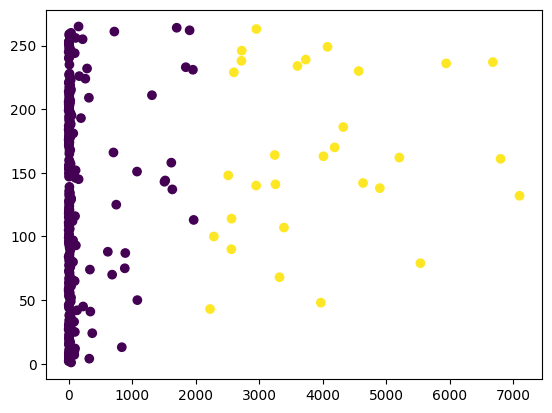

In [13]:
plt.scatter(location_demand_df['Demand'], location_demand_df['Location'], c = kmeans.labels_)

In [14]:
def group_locations(location_demand_df, group_num):
    locations = [[] for i in range(group_num)]
    for i in range(group_num):
        demand_values = location_demand_df['Demand'].to_numpy().reshape(-1, 1)[kmeans.labels_ == i]
        locations[i].append(
            location_demand_df[(location_demand_df['Demand'] >= np.min(demand_values))
            &(location_demand_df['Demand'] <= np.max(demand_values))]['Location'].values)
    
    return locations

In [15]:
centroids = kmeans.cluster_centers_
sorted_group_labels = np.argsort(centroids[:, 1])[-3:][::-1]

In [16]:
grouped_locations = group_locations(location_demand_df, GROUP_NUM)

In [17]:
high_demand_location_df = grouped_locations[sorted_group_labels[0]][0]
mid_deman_location_df = grouped_locations[sorted_group_labels[1]][0]
#low_demand_location_df = grouped_locations[sorted_group_labels[2]][0]

In [20]:
high_demand_df = features_df[features_df['Location'].isin(high_demand_location_df)].reset_index(drop = True)
high_demand_df['group'] = 1

mid_demand_df = features_df[features_df['Location'].isin(mid_deman_location_df)].reset_index(drop = True)
mid_demand_df['group'] = 0
#low_demand_df = features_df[features_df['Location'].isin(low_demand_location_df)].reset_index(drop = True)

In [47]:
features_df = pd.concat([high_demand_df, mid_demand_df], axis = 0)
features_df = features_df.sort_values(by = ['Location', 'Date'])

## Split Train and Test Data

In [49]:
def train_test_splitting(dataset, TEST_START_DATE):

    train_df = dataset[dataset['Date'] < TEST_START_DATE]
    test_df = dataset[dataset['Date'] >= TEST_START_DATE]

    return train_df, test_df

In [50]:
train_df, test_df = train_test_splitting(features_df, TEST_START_DATE)

In [51]:
print(f'train dataframe shape : {train_df.shape}')
train_df.head()

train dataframe shape : (19912, 20)


,Location,Date,Demand,Previous_day_demand,Previous_2day_demand,Previous_3day_demand,Previous_4day_demand,Previous_5day_demand,Previous_6day_demand,Previous_week_demand,Previous_8day_demand,Previous_9day_demand,Previous_10day_demand,Previous_11day_demand,Previous_12day_demand,Previous_13day_demand,Previous_2week_demand,Day_of_week,Day_of_month,group
0,1,2023-01-15,19.0,7.0,21.0,8.0,9.0,4.0,14.0,12.0,6.0,11.0,15.0,7.0,27.0,31.0,40.0,6,15,0
1,1,2023-01-16,21.0,19.0,7.0,21.0,8.0,9.0,4.0,14.0,12.0,6.0,11.0,15.0,7.0,27.0,31.0,0,16,0
2,1,2023-01-17,18.0,21.0,19.0,7.0,21.0,8.0,9.0,4.0,14.0,12.0,6.0,11.0,15.0,7.0,27.0,1,17,0
3,1,2023-01-18,10.0,18.0,21.0,19.0,7.0,21.0,8.0,9.0,4.0,14.0,12.0,6.0,11.0,15.0,7.0,2,18,0
4,1,2023-01-19,9.0,10.0,18.0,21.0,19.0,7.0,21.0,8.0,9.0,4.0,14.0,12.0,6.0,11.0,15.0,3,19,0


In [52]:
print(f'test dataframe shape : {test_df.shape}')
test_df.head()

test dataframe shape : (7860, 20)


,Location,Date,Demand,Previous_day_demand,Previous_2day_demand,Previous_3day_demand,Previous_4day_demand,Previous_5day_demand,Previous_6day_demand,Previous_week_demand,Previous_8day_demand,Previous_9day_demand,Previous_10day_demand,Previous_11day_demand,Previous_12day_demand,Previous_13day_demand,Previous_2week_demand,Day_of_week,Day_of_month,group
76,1,2023-04-01,13.0,13.0,13.0,7.0,14.0,3.0,14.0,15.0,9.0,21.0,9.0,6.0,14.0,33.0,25.0,5,1,0
77,1,2023-04-02,17.0,13.0,13.0,13.0,7.0,14.0,3.0,14.0,15.0,9.0,21.0,9.0,6.0,14.0,33.0,6,2,0
78,1,2023-04-03,9.0,17.0,13.0,13.0,13.0,7.0,14.0,3.0,14.0,15.0,9.0,21.0,9.0,6.0,14.0,0,3,0
79,1,2023-04-04,12.0,9.0,17.0,13.0,13.0,13.0,7.0,14.0,3.0,14.0,15.0,9.0,21.0,9.0,6.0,1,4,0
80,1,2023-04-05,18.0,12.0,9.0,17.0,13.0,13.0,13.0,7.0,14.0,3.0,14.0,15.0,9.0,21.0,9.0,2,5,0


# Model Training

### **Ridge Regression**

#### Model Tuning

In [53]:
def grid_search(model, test_parameters, train_data, cv = None, feature_list = FEATURE_LIST):
    gs = GridSearchCV(
        estimator = model, 
        param_grid = test_parameters, 
        scoring = 'neg_root_mean_squared_error', 
        cv = cv, 
        n_jobs = -1
        )
    
    gs.fit(train_data[feature_list], train_data['Demand'])
    return gs.best_params_, gs.best_score_

In [70]:
model = Ridge()
best_params, best_score = grid_search(
    model, 
    {'alpha':[0, 1, 10, 100]},
    train_df, 
    cv = 5, 
    feature_list = FEATURE_LIST
    )

print(best_params, best_score)

{'alpha': 100} -88.81366521406218


#### Prediction

In [55]:
def model_predict(model, train_data, test_data, feature_list):

    model.fit(train_data[feature_list], train_data['Demand'])


    train_predict_df  = model.predict(train_data[feature_list])
    test_predict_df  = model.predict(test_data[feature_list])

    return train_predict_df, test_predict_df

In [71]:
model = Ridge(**best_params)
train_prediction_df , test_prediction_df  = model_predict(model, train_df, test_df, FEATURE_LIST)

#### Visualization

In [57]:
def add_day_of_year(data):
    data['day_year'] = 0
    start_date = data['Date'].min()

    for index, row in data.iterrows():

        curr_date = row['Date']
        day_number = (curr_date - start_date).days

        data.at[index, 'day_year'] = day_number
    return data

In [58]:
def prediction_visualization(train_data, test_data, train_prediction_df, test_prediction_df):


    train_data = add_day_of_year(train_data)
    test_data = add_day_of_year(test_data)

    predicted_train_df = train_data
    predicted_test_df = test_data
    predicted_train_df['Predicted'] = train_prediction_df
    predicted_test_df['Predicted'] = test_prediction_df

    train_data = train_data.groupby('day_year')['Demand'].sum()
    test_data = test_data.groupby('day_year')['Demand'].sum()
    predicted_train_df = predicted_train_df.groupby('day_year')['Predicted'].sum()
    predicted_test_df = predicted_test_df.groupby('day_year')['Predicted'].sum()

    plt.title('Train')
    plt.plot(train_data)
    plt.plot(predicted_train_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()

    plot_length = len(test_data)
    plt.title('Test')
    plt.plot(test_data)
    plt.plot(predicted_test_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()

C:\Users\bardia\AppData\Local\Temp\ipykernel_4680\2975102461.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['day_year'] = 0


C:\Users\bardia\AppData\Local\Temp\ipykernel_4680\2975102461.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['day_year'] = 0
C:\Users\bardia\AppData\Local\Temp\ipykernel_4680\2246591508.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted_train_df['Predicted'] = train_prediction_df
C:\Users\bardia\AppData\Local\Temp\ipykernel_4680\2246591508.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

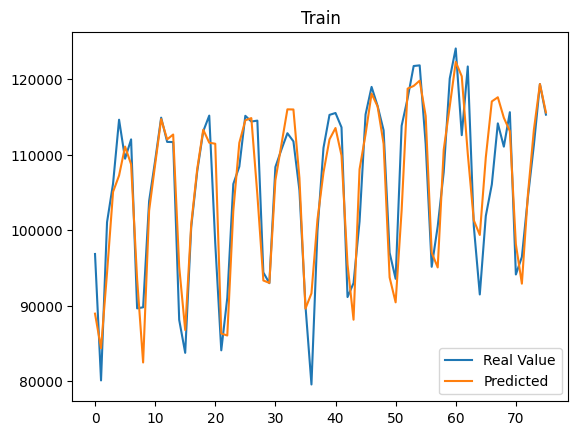

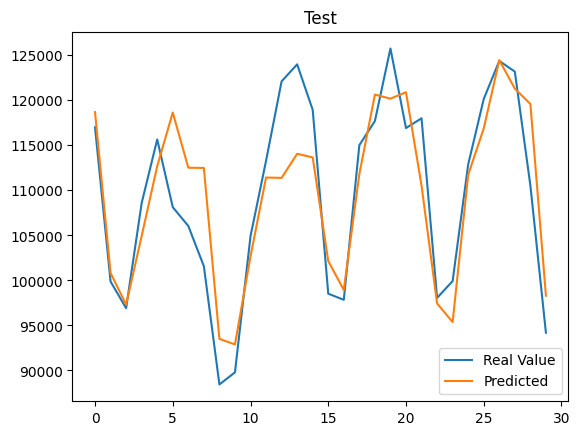

In [59]:
prediction_visualization(train_df, test_df, train_prediction_df, test_prediction_df)

#### Evaluation

In [60]:
def evaluate(metric, metric_name, true_values, predicted_values):
    print(f'{metric_name} : {metric(true_values, predicted_values)}')

In [61]:
def evaluation(model_name, train_data, test_data, train_prediction_df, test_prediction_df):
    print(f'{model_name} train scores:')


    evaluate(mean_absolute_error, 'MAE', train_data['Demand'], train_prediction_df)
    evaluate(mean_squared_error, 'MSE', train_data['Demand'], train_prediction_df)
    evaluate(mean_absolute_percentage_error, 'MAPE', train_data['Demand'], train_prediction_df)

    print(f'{model_name} test scores:')

    evaluate(mean_absolute_error, 'MAE', test_data['Demand'], test_prediction_df)
    evaluate(mean_squared_error, 'MSE', test_data['Demand'], test_prediction_df)
    evaluate(mean_absolute_percentage_error, 'MAPE', test_data['Demand'], test_prediction_df)


In [72]:
evaluation('Ridge Regression', train_df, test_df, train_prediction_df, test_prediction_df)

Ridge Regression train scores:
MAE : 28.88288575816719
MSE : 8634.014267007595
MAPE : 827077090680569.2
Ridge Regression test scores:
MAE : 29.500384320400833
MSE : 7908.471644481529
MAPE : 816038994473673.1


# File Saving

In [63]:
def save_predictions(dataset, path):
    dataset.to_parquet(path, index=False)

In [64]:
def prediction_labeling(pred_df, labeled_df):
    pred_df = pd.DataFrame(pred_df, columns = ['Predicted_demand'])
    labeled_df.reset_index(inplace = True)
    labeled_prediction_df = labeled_df[['Location', 'Date']]
    labeled_prediction_df['Predicted_demand'] = pred_df
    return labeled_prediction_df

In [65]:
labeled_test_prediction_df = prediction_labeling(test_prediction_df, test_df)
labeled_train_prediction_df = prediction_labeling(train_prediction_df, train_df)

C:\Users\bardia\AppData\Local\Temp\ipykernel_4680\1857597426.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_prediction_df['Predicted_demand'] = pred_df
C:\Users\bardia\AppData\Local\Temp\ipykernel_4680\1857597426.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_prediction_df['Predicted_demand'] = pred_df


In [66]:
print(f'labeled prediction dataframe shape : {labeled_test_prediction_df.shape}')
labeled_test_prediction_df.head()

labeled prediction dataframe shape : (7860, 3)


,Location,Date,Predicted_demand
0,1,2023-04-01,18.718862
1,1,2023-04-02,20.380660
2,1,2023-04-03,10.843824
3,1,2023-04-04,10.881477
4,1,2023-04-05,10.410484


In [67]:
print(f'labeled prediction dataframe shape : {labeled_train_prediction_df.shape}')
labeled_train_prediction_df.head()

labeled prediction dataframe shape : (19912, 3)


,Location,Date,Predicted_demand
0,1,2023-01-15,21.069993
1,1,2023-01-16,24.382257
2,1,2023-01-17,16.425047
3,1,2023-01-18,14.010358
4,1,2023-01-19,14.111033


In [68]:
save_predictions(labeled_train_prediction_df, OUTPUT_PATH_TRAIN)
save_predictions(labeled_test_prediction_df, OUTPUT_PATH_TEST)